In [ ]:
import os
import cv2
import time
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input

import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__, np.__version__

('2.13.0', '1.23.5')

In [ ]:
# Setting random seeds to enable consistency while testing.
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

ROOT = './drive/MyDrive/CroppedFaces'

In [ ]:
def read_image(index):
    path = os.path.join(ROOT, index[0], index[1])
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


In [ ]:
def split_dataset(directory, split=0.9):
    folders = os.listdir(directory)
    num_train = int(len(folders)*split)

    random.shuffle(folders)

    train_list, test_list = {}, {}

    # Creating Train-list
    for folder in folders[:num_train]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        train_list[folder] = num_files

    # Creating Test-list
    for folder in folders[num_train:]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        test_list[folder] = num_files

    return train_list, test_list

train_list, test_list = split_dataset(ROOT, split=0.9)
print("Length of training list:", len(train_list))
print("Length of testing list :", len(test_list))

# train_list, test list contains the folder names along with the number of files in the folder.
print("\nTest List:", test_list)

Length of training list: 201
Length of testing list : 23

Test List: {'709': 37, 'Aftab_Shivdasani': 28, '1176': 22, '719': 25, 'Amitabh_Bachchan': 24, 'Shahid_Kapoor': 28, 'Naseeruddin_Shah': 27, 'Tamannaah_Bhatia': 29, '1151': 10, 'Kajal_Aggarwal': 30, '1423': 19, '824': 14, 'Zareen_Khan': 29, '667': 11, '526': 19, '1088': 14, '117': 33, '163': 17, '1247': 11, 'Abhishek': 50, '1580': 10, 'Hrithik_Roshan': 25, '6': 16}


In [ ]:
def create_triplets(directory, folder_list, max_files=10):
    triplets = []
    folders = list(folder_list.keys())

    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)

        for i in range(num_files-1):
            for j in range(i+1, num_files):
                anchor = (folder, files[i])
                positive = (folder, files[j])

                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                neg_file = os.listdir(os.path.join(directory, neg_folder))[random.randint(0, folder_list[neg_folder]-1)]
                negative = (neg_folder, neg_file)

                triplets.append((anchor, positive, negative))

    random.shuffle(triplets)
    return triplets

In [ ]:
train_triplet = create_triplets(ROOT, train_list)
test_triplet  = create_triplets(ROOT, test_list)

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))

print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet[i])

Number of training triplets: 9045
Number of testing triplets : 1035

Examples of triplets:
(('309', '23.jpg'), ('309', '25.jpg'), ('Mrunal_Thakur', '12.jpg'))
(('378', '6.jpg'), ('378', '4.jpg'), ('Varun_Dhawan', '10.jpg'))
(('Abhishek_Bachchan', '13.jpg'), ('Abhishek_Bachchan', '14.jpg'), ('205', '0.jpg'))
(('Shruti_Haasan', '116.jpg'), ('Shruti_Haasan', '113.jpg'), ('Amrita_Rao', '104.jpg'))
(('Disha_Patani', '1.jpg'), ('Disha_Patani', '10.jpg'), ('1557', '4.jpg'))


In [ ]:
def get_batch(triplet_list, batch_size=256, preprocess=True):
    batch_steps = len(triplet_list)//batch_size

    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []

        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a))
            positive.append(read_image(p))
            negative.append(read_image(n))
            j+=1

        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)

        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)

        yield ([anchor, positive, negative])

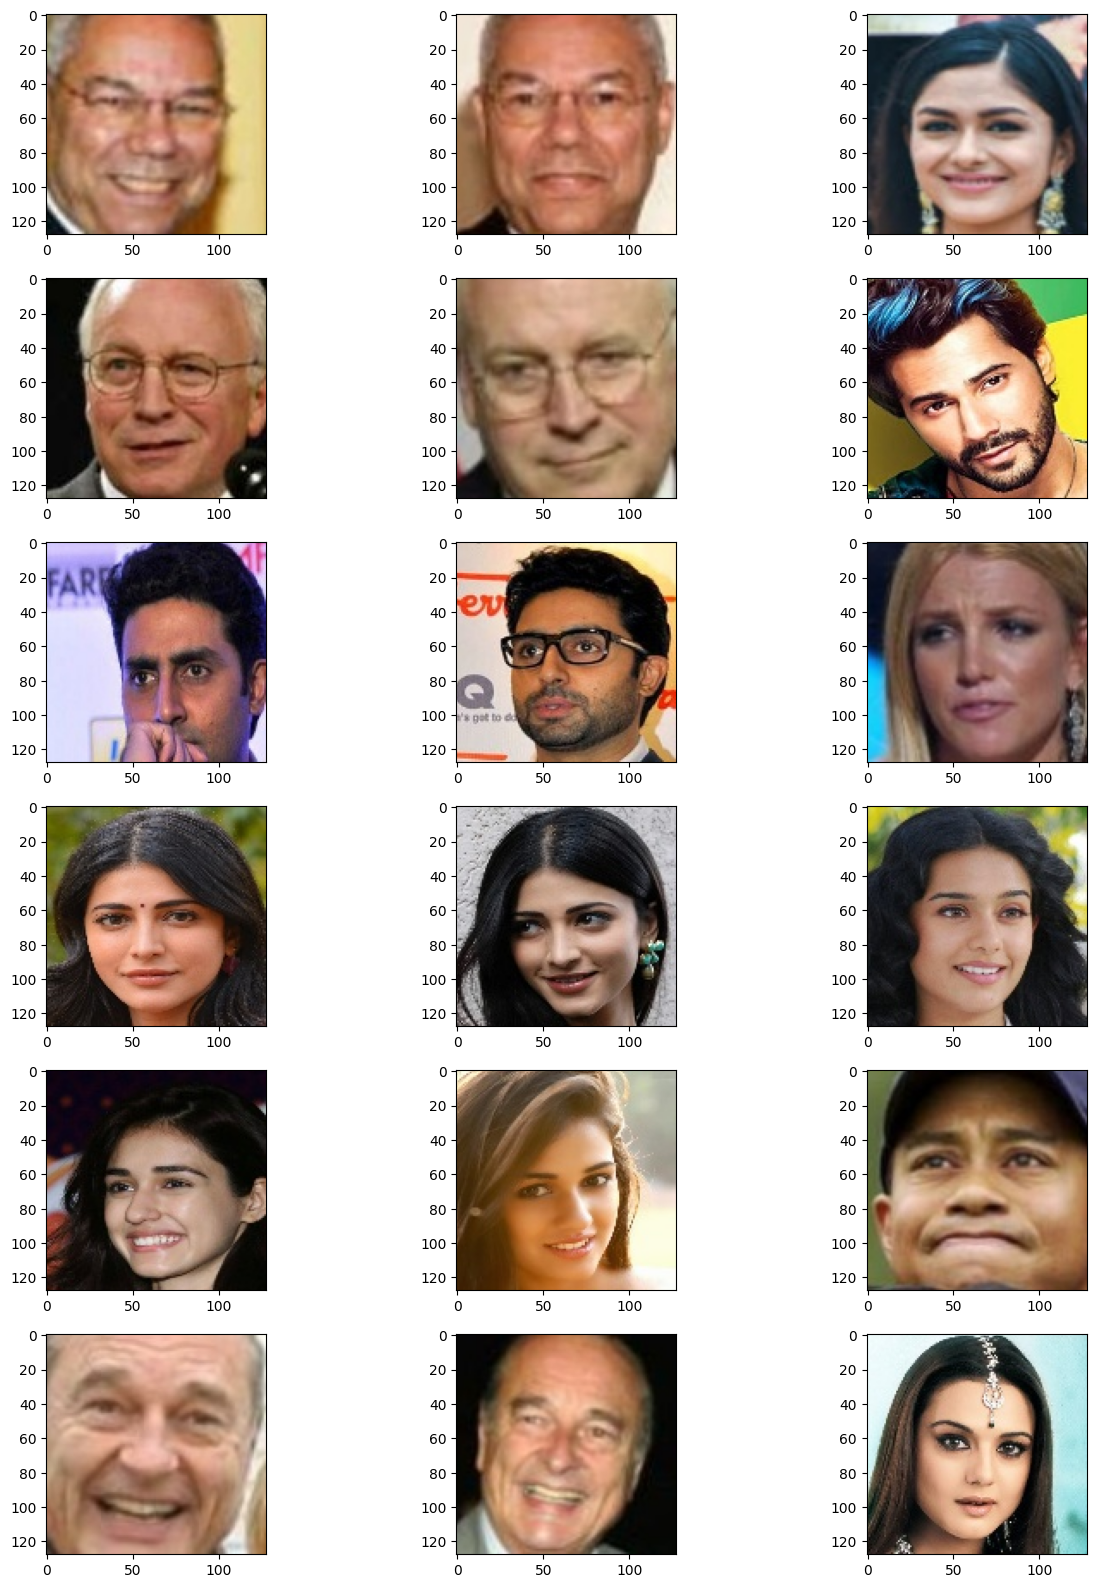

In [ ]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplet, batch_size=num_plots, preprocess=False):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break


In [ ]:
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
def get_encoder(input_shape):
    """ Returns the image encoding model """

    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )

    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model

In [ ]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)

    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")

    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)

    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )

    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Anchor_Input (InputLayer)   [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Positive_Input (InputLayer  [(None, 128, 128, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 Negative_Input (InputLayer  [(None, 128, 128, 3)]        0         []                            
 )                                                                                                
                   

In [ ]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()

        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [ ]:
siamese_model = SiameseModel(siamese_network)

optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

In [ ]:
def test_on_triplets(batch_size = 256):
    pos_scores, neg_scores = [], []

    for data in get_batch(test_triplet, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])

    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)

    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [ ]:
checkpoint = tf.train.Checkpoint(model=siamese_model,optim=optimizer)

batch_size = 128

max_acc = 0
train_loss = []
test_metrics = []

In [ ]:
save_interval = 20
save_all = False
epochs = 50

for epoch in range(1, epochs+1):
    t = time.time()

    # Training the model on train data
    epoch_loss = []
    for data in get_batch(train_triplet, batch_size=batch_size):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")

    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]

    # Saving the model weights
    if accuracy>=max_acc:
        checkpoint.save(f'./siamese-model-{epoch}')
        max_acc = accuracy

    if save_all or epoch%save_interval==0:
        checkpoint.save(f'./siamese-model-{epoch}')

# Saving the model after all epochs run
checkpoint.save(f'./siamese-model-{epoch}')


EPOCH: 1 	 (Epoch done in 1390 sec)
Loss on train    = 0.36373
1/1 [==============================] - 3s 3s/step
Accuracy on test = 0.87729

EPOCH: 2 	 (Epoch done in 110 sec)
Loss on train    = 0.21456
1/1 [==============================] - 0s 29ms/step
Accuracy on test = 0.88792

EPOCH: 3 	 (Epoch done in 117 sec)
Loss on train    = 0.16985
1/1 [==============================] - 0s 33ms/step
Accuracy on test = 0.89758

EPOCH: 4 	 (Epoch done in 110 sec)
Loss on train    = 0.14717
1/1 [==============================] - 0s 35ms/step
Accuracy on test = 0.90918

EPOCH: 5 	 (Epoch done in 111 sec)
Loss on train    = 0.12368
1/1 [==============================] - 0s 46ms/step
Accuracy on test = 0.89758

EPOCH: 6 	 (Epoch done in 116 sec)
Loss on train    = 0.11185
1/1 [==============================] - 0s 35ms/step
Accuracy on test = 0.90918

EPOCH: 7 	 (Epoch done in 110 sec)
Loss on train    = 0.08206
1/1 [==============================] - 0s 33ms/step
Accuracy on test = 0.89952

EPOCH:

'./siamese-model-50-8'

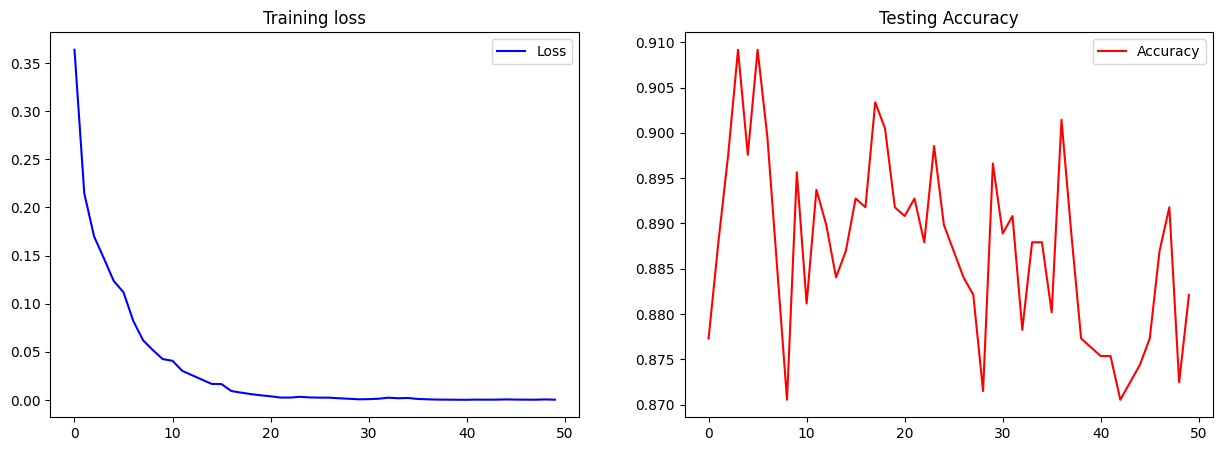

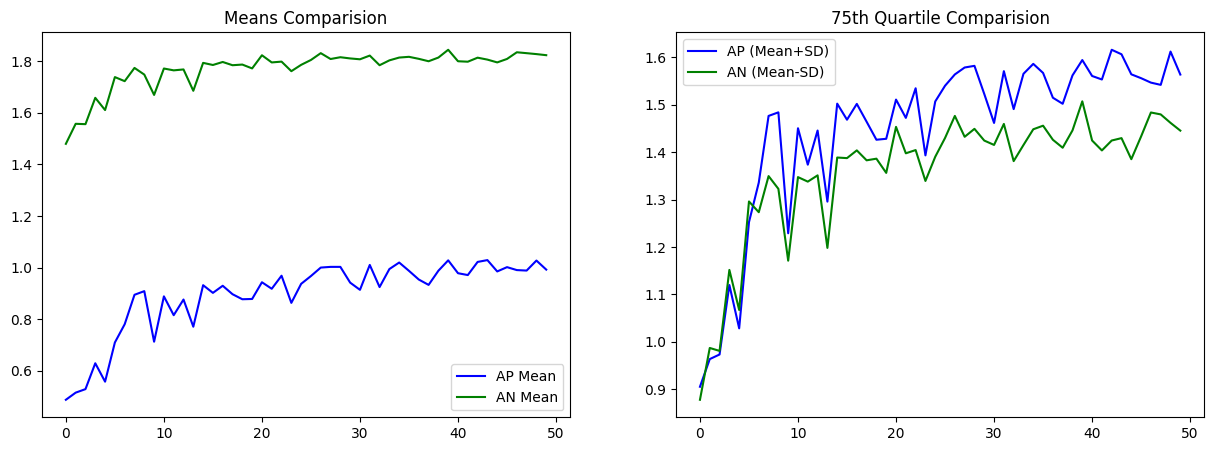

In [ ]:
def plot_metrics(loss, metrics, epochs = None):
    # Extracting individual metrics from metrics
    accuracy = metrics[:, 0]
    ap_mean  = metrics[:, 1]
    an_mean  = metrics[:, 2]
    ap_stds  = metrics[:, 3]
    an_stds  = metrics[:, 4]

    plt.figure(figsize=(15,5))

    # Plotting the loss over epochs
    plt.subplot(121)
    plt.plot(loss[:epochs], 'b', label='Loss')
    plt.title('Training loss')
    plt.legend()

    # Plotting the accuracy over epochs
    plt.subplot(122)
    plt.plot(accuracy[:epochs], 'r', label='Accuracy')
    plt.title('Testing Accuracy')
    plt.legend()

    plt.figure(figsize=(15,5))

    # Comparing the Means over epochs
    plt.subplot(121)
    plt.plot(ap_mean[:epochs], 'b', label='AP Mean')
    plt.plot(an_mean[:epochs], 'g', label='AN Mean')
    plt.title('Means Comparision')
    plt.legend()

    # Plotting the accuracy
    ap_75quartile = (ap_mean+ap_stds)
    an_75quartile = (an_mean-an_stds)
    plt.subplot(122)
    plt.plot(ap_75quartile[:epochs], 'b', label='AP (Mean+SD)')
    plt.plot(an_75quartile[:epochs], 'g', label='AN (Mean-SD)')
    plt.title('75th Quartile Comparision')
    plt.legend()

test_metrics = np.array(test_metrics)
plot_metrics(train_loss, test_metrics)
